In [1]:
!pip install scikit-posthocs
!pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.1 MB/s eta 0:00:00


In [2]:
import zipfile

# Define the path to the zip file
zip_path = "/content/Data for modelling.zip"
extract_path = "/content/Data_for_modelling"  # Folder to extract files

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [210]:
import pandas as pd
import numpy as np
ticker = 'VNINDEX'
df = pd.read_csv(f'/content/Data_for_modelling/Data for modelling/Frontier/VNI/{ticker}.csv', index_col=0)
data = pd.read_csv(f'/content/Data_for_modelling/Data for modelling/Frontier/VNI/{ticker}_return.csv')

data.index = df['Date']
data = data.dropna()

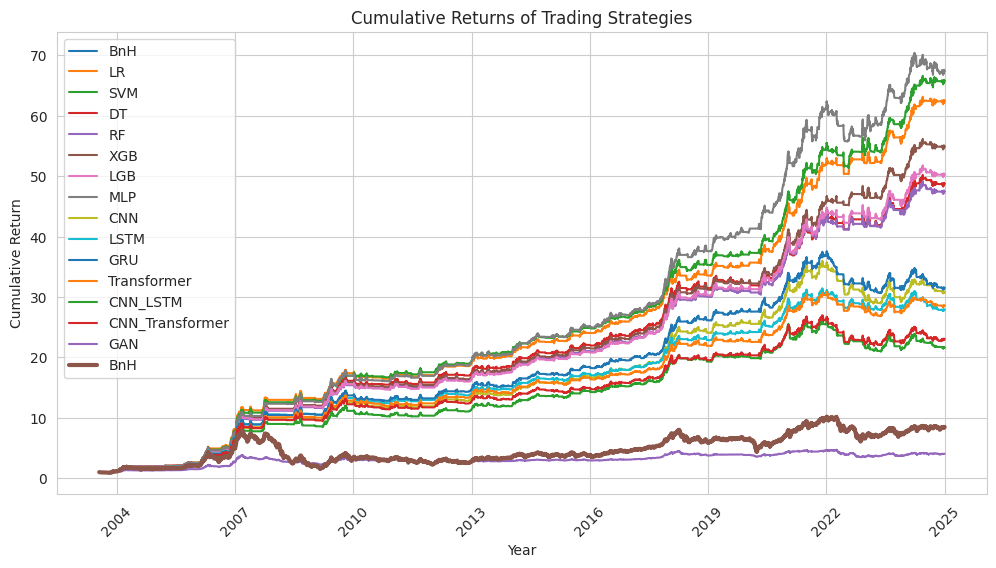

In [211]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure index is datetime
data.index = pd.to_datetime(data.index)

# Compute cumulative returns
cumulative_returns = (1 + data).cumprod()

# Plot
plt.figure(figsize=(12, 6))

for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

plt.plot(cumulative_returns.index, cumulative_returns['BnH'], label='BnH', linewidth=3)

plt.title('Cumulative Returns of Trading Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()

# Format x-axis to show only years
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))  # Show every 3 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as YYYY
plt.xticks(rotation=45)  # Rotate labels if needed

plt.legend()
plt.title('Cumulative Returns of Trading Strategies')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.grid()
plt.savefig(f'/content/Data_for_modelling/Data for modelling/Frontier/VNI/{ticker}_1.png')

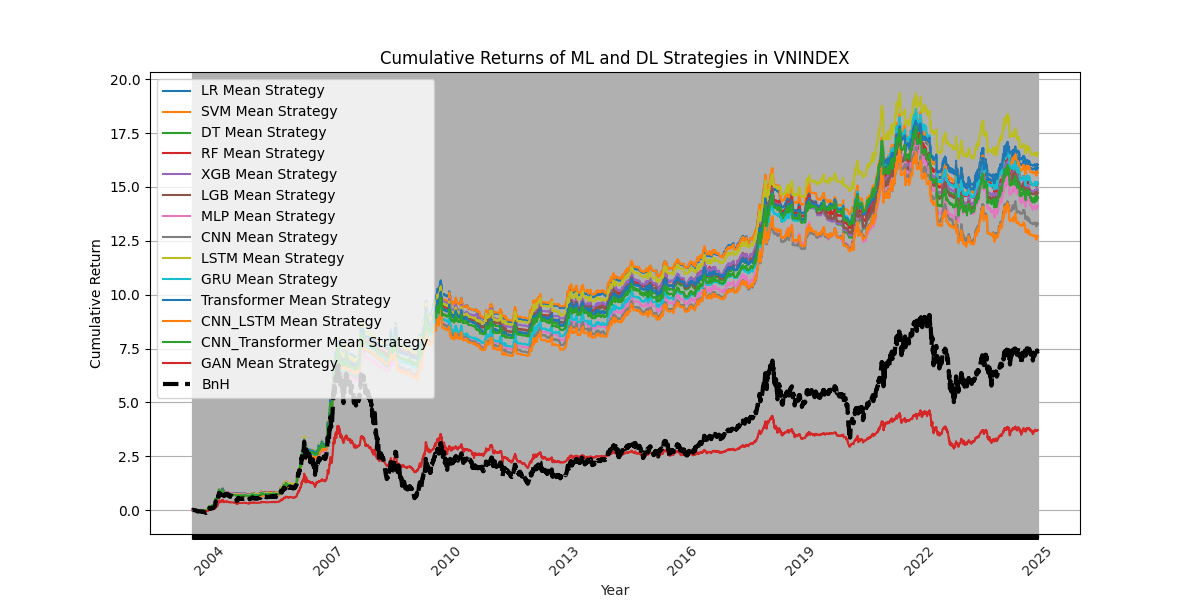

In [212]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Import for Colab

# Load the two images
first_image = cv2.imread(f'/content/Data_for_modelling/Data for modelling/Frontier/VNI/{ticker}.png')   # Update path
second_image = cv2.imread(f'/content/Data_for_modelling/Data for modelling/Frontier/VNI/{ticker}_1.png') # Update path

# Convert images to grayscale to detect the date axis
gray_second = cv2.cvtColor(second_image, cv2.COLOR_BGR2GRAY)

# Crop the date axis from the second image (adjust if needed)
y_start = int(second_image.shape[0] * 0.9)  # Lower 10% contains the date axis
date_axis = second_image[y_start:, :]

# Remove the incorrect date axis from the first image (set that region to white)
first_image[y_start:, :] = 255  # White background

# Overlay the new date axis onto the first image
first_image[y_start:, :] = date_axis

# Save and display the fixed image
cv2.imwrite(f'/content/Data_for_modelling/Data for modelling/Frontier/VNI/{ticker}_final.png', first_image)
cv2_imshow(first_image)  # Use this instead of cv2.imshow()


# **Compare return**

In [213]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp

# Reshape data: Convert from wide format to long format
data_long = data.reset_index().melt(id_vars="Date", var_name="model", value_name="daily_return")

# Get unique models (including 'BnH')
models = data.columns.tolist()

# Convert data to the format required for Kruskal-Wallis test
returns_data = [data[model].dropna().values for model in models]  # Drop NaNs

# Perform Kruskal-Wallis test
print("\n📊 Performing Kruskal-Wallis test on daily returns...\n")
test_stat, p_value = stats.kruskal(*returns_data)

# Display Kruskal-Wallis test result
if p_value < 0.05:
    print(f"⚠️ Kruskal-Wallis Test Result: p={p_value:.4f} → Significant Difference Found!")

    # Perform Nemenyi post-hoc test
    nemenyi_test = sp.posthoc_nemenyi(data_long, val_col="daily_return", group_col="model")

    # Format Nemenyi results to 4 decimal places
    nemenyi_test = nemenyi_test.map(lambda x: f"{x:.4f}")

    # Display Nemenyi test results
    print("\n📊 Nemenyi Test Results for Daily Returns:\n")
    print(nemenyi_test.to_string(index=True))
else:
    print(f"✅ No significant difference found (p={p_value:.4f})")




📊 Performing Kruskal-Wallis test on daily returns...

✅ No significant difference found (p=0.1518)


In [214]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# Calculate daily return statistics for each model
summary_stats = pd.DataFrame(index=data.columns)

summary_stats['Mean_Return'] = data.mean()  # Mean daily return
summary_stats['Std_Dev'] = data.std()  # Standard deviation (volatility)
summary_stats['Skewness'] = data.apply(skew)  # Skewness (asymmetry)
summary_stats['Kurtosis'] = data.apply(kurtosis)  # Kurtosis (tail risk)

# Display results rounded to 4 decimal places
print(summary_stats.round(4))

                 Mean_Return  Std_Dev  Skewness  Kurtosis
BnH                   0.0005   0.0138   -0.2136    2.2455
LR                    0.0008   0.0064    1.4186   17.2304
SVM                   0.0008   0.0063    1.5119   16.3270
DT                    0.0007   0.0066    1.0806   16.0166
RF                    0.0007   0.0065    1.2036   15.7518
XGB                   0.0008   0.0066    1.1611   16.5468
LGB                   0.0008   0.0066    1.1206   16.0778
MLP                   0.0008   0.0065    1.2335   14.7159
CNN                   0.0007   0.0066    0.9707   13.8388
LSTM                  0.0006   0.0064    1.2023   16.6219
GRU                   0.0007   0.0064    1.2179   15.1012
Transformer           0.0006   0.0064    1.2627   16.4104
CNN_LSTM              0.0006   0.0066    0.8413   14.3770
CNN_Transformer       0.0006   0.0065    1.0130   14.6962
GAN                   0.0003   0.0071   -0.1415    4.8686


In [215]:
metrics = ['Total Return [%]', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown [%]']
performance = pd.read_csv(f'/content/Data_for_modelling/Data for modelling/Frontier/VNI/{ticker}_trading.csv', index_col=0)
print(performance.loc[metrics])

                                  LR                 SVM                  DT  \
Total Return [%]  1587.8787015644414  1566.6747175399648  1447.1415188154635   
Sharpe Ratio      1.4751706963683124   1.465460990648897  1.3862064726198817   
Sortino Ratio      2.392311586855833  2.3711272208374607  2.2034883481492376   
Max Drawdown [%]   26.49109162818535    28.5701353239003   28.25935797214773   

                                  RF                 XGB                 LGB  \
Total Return [%]  1515.0200528508478  1484.6124758975325  1472.3678528106714   
Sharpe Ratio      1.4343656233957174  1.4175145635037467  1.4062917856158972   
Sortino Ratio     2.2961079716529094   2.268647583789417   2.241713020142188   
Max Drawdown [%]   28.06323429156676  26.846760247947618  27.260709933859935   

                                 MLP                 CNN                LSTM  \
Total Return [%]  1409.4834748695666  1328.7464547180061  1655.0462303497272   
Sharpe Ratio       1.373888345645671  

In [216]:
import vectorbt as vbt
bnh = pd.read_csv(f'/content/Data_for_modelling/Data for modelling/Frontier/VNI/{ticker}.csv', index_col=0)
bnh.index = bnh['Date']
bnh['signal'] = [1]*len(bnh)

In [217]:
data['close'] = bnh['close']
data['signal'] = bnh['signal']

In [218]:
p1 = vbt.Portfolio.from_signals(
        close=bnh['close'],
        entries=bnh.signal==1,  # Entries where signal is 1
        exits=bnh.signal == 0,  # Exits where signal is 0
        size=1,  # Assuming equal position size
        fixed_fees=0.001,  # Example transaction cost
        slippage=0.001,
        freq='1d'
    )
p1.stats(agg_func=None).T.loc[metrics]

,0
Total Return [%],736.749703
Sharpe Ratio,0.681349
Sortino Ratio,0.963167
Max Drawdown [%],79.883315


# **Accuracy**

In [219]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp
import numpy as np
import os

# Define parameters
models = ['LR', 'SVM', 'DT', 'RF', 'XGB', 'LGB', 'MLP',
          'CNN', 'LSTM', 'GRU', 'Transformer',
          'CNN_LSTM', 'CNN_Transformer', 'GAN']

base_path = "/content/Data_for_modelling/Data for modelling/Frontier/VNI/"


# Load all model data into a single DataFrame
data_list = []
for model in models:
    file_path = os.path.join(base_path, f"{ticker}_{model}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['model'] = model  # Add model name column
        data_list.append(df)
        print(f"✅ Loaded {model} data successfully.")
    else:
        print(f"⚠️ {model} file not found at {file_path}. Skipping.")

# Merge all data
data = pd.concat(data_list, ignore_index=True)

# Get metric columns (excluding 'ticker' and 'model')
metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'MCC', 'AUC']

# Store results
kruskal_results = {}
nemenyi_results = {}

# Loop through each metric
for metric in metrics:
    print(f"\n📊 Performing Kruskal-Wallis test for {metric}...\n")

    # Extract values for all models
    metric_values = [data[data['model'] == model][metric] for model in models if model in data['model'].unique()]

    # Perform Kruskal-Wallis test
    test_stat, p_value = stats.kruskal(*metric_values)

    # Store Kruskal-Wallis results
    kruskal_results[metric] = {'p_value': p_value}

    # Print Kruskal-Wallis results
    if p_value < 0.05:
        print(f"⚠️ Kruskal-Wallis Result: p={p_value:.4f} → Significant Difference!")

        # Perform Nemenyi post-hoc test (Corrected version)
        nemenyi_test = sp.posthoc_nemenyi(data, val_col=metric, group_col='model')

        # Store Nemenyi results
        nemenyi_results[metric] = nemenyi_test

        print(f"\n📊 Nemenyi Test Results for {metric}:\n")
        print(nemenyi_test.round(4))
    else:
        print(f"✅ No significant difference found (p={p_value:.4f})")

# Print summary of Kruskal-Wallis tests
print("\n🔹 Summary of Kruskal-Wallis Test Results:")
kruskal_summary_df = pd.DataFrame(kruskal_results).T
print(kruskal_summary_df.round(4))

# Print summary of Nemenyi test results (if any)
if nemenyi_results:
    print("\n🔹 Summary of Nemenyi Test Results:")
    for metric, result in nemenyi_results.items():
        print(f"\n📊 Nemenyi test for {metric}:\n")
        print(result.round(4))

✅ Loaded LR data successfully.
✅ Loaded SVM data successfully.
✅ Loaded DT data successfully.
✅ Loaded RF data successfully.
✅ Loaded XGB data successfully.
✅ Loaded LGB data successfully.
✅ Loaded MLP data successfully.
✅ Loaded CNN data successfully.
✅ Loaded LSTM data successfully.
✅ Loaded GRU data successfully.
✅ Loaded Transformer data successfully.
✅ Loaded CNN_LSTM data successfully.
✅ Loaded CNN_Transformer data successfully.
✅ Loaded GAN data successfully.

📊 Performing Kruskal-Wallis test for Accuracy...

⚠️ Kruskal-Wallis Result: p=0.0000 → Significant Difference!

📊 Nemenyi Test Results for Accuracy:

                    CNN  CNN_LSTM  CNN_Transformer      DT     GAN     GRU  \
CNN              1.0000    0.9999           0.9747  0.2886  0.0000  0.9990   
CNN_LSTM         0.9999    1.0000           1.0000  0.9236  0.0005  1.0000   
CNN_Transformer  0.9747    1.0000           1.0000  0.9986  0.0138  1.0000   
DT               0.2886    0.9236           0.9986  1.0000  0.5117

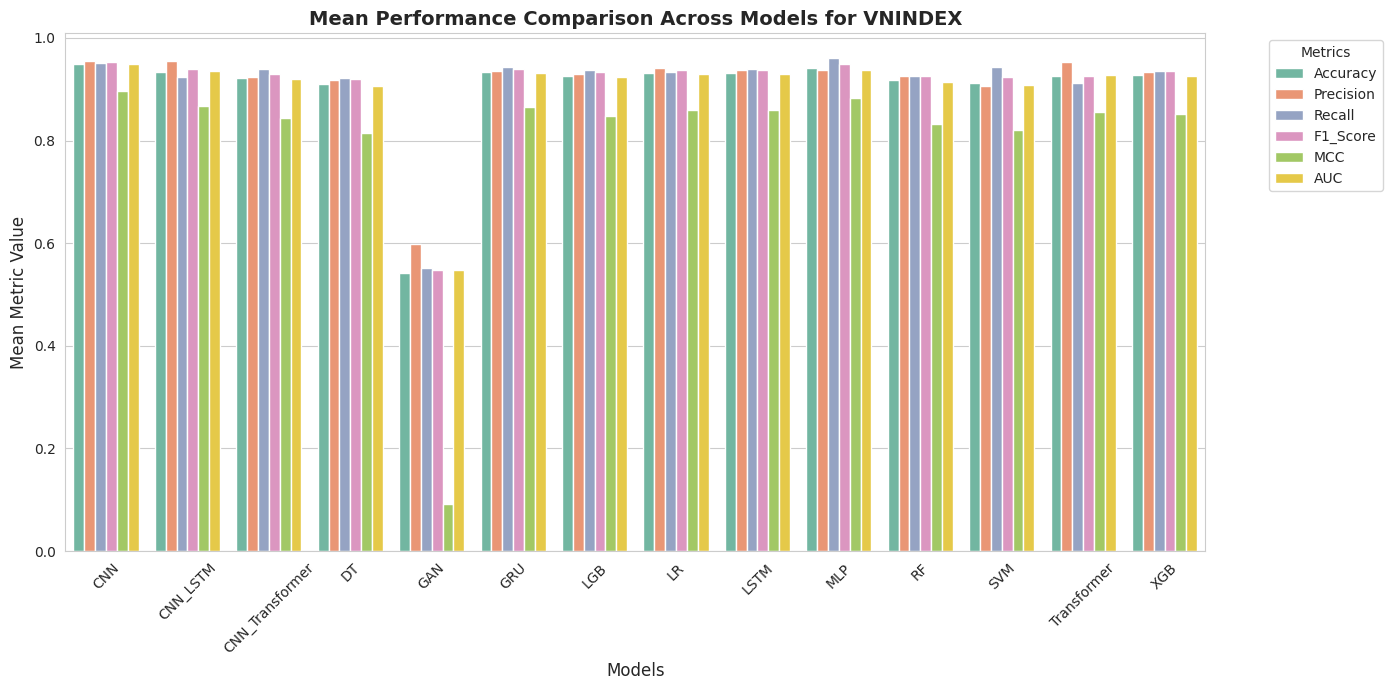

In [220]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp
import os
import matplotlib.pyplot as plt
import seaborn as sns
mean_performance = data.groupby('model')[metrics].mean().reset_index()

plt.figure(figsize=(14, 7))

# Reshape the data for Seaborn
data_melted = mean_performance.melt(id_vars=['model'], value_vars=metrics, var_name='Metric', value_name='Mean Value')

# Create a grouped bar plot
sns.set_style("whitegrid")
ax = sns.barplot(x='model', y='Mean Value', hue='Metric', data=data_melted, palette="Set2")

# Rotate x-axis labels for readability
plt.xticks(rotation=45)
plt.title(f"Mean Performance Comparison Across Models for {ticker}", fontsize=14, fontweight='bold')
plt.xlabel("Models", fontsize=12)
plt.ylabel("Mean Metric Value", fontsize=12)
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

In [221]:
mean_performance.round(4)

,model,Accuracy,Precision,Recall,F1_Score,MCC,AUC
0,CNN,0.9486,0.9543,0.9516,0.9527,0.8960,0.9485
1,CNN_LSTM,0.9343,0.9554,0.9234,0.9386,0.8677,0.9344
2,CNN_Transformer,0.9218,0.9246,0.9392,0.9301,0.8440,0.9205
3,DT,0.9098,0.9173,0.9210,0.9189,0.8149,0.9064
4,GAN,0.5421,0.5975,0.5508,0.5468,0.0919,0.5481
5,GRU,0.9330,0.9362,0.9441,0.9395,0.8645,0.9319
6,LGB,0.9259,0.9303,0.9366,0.9333,0.8481,0.9233
7,LR,0.9309,0.9421,0.9329,0.9374,0.8586,0.9294
8,LSTM,0.9308,0.9367,0.9396,0.9377,0.8595,0.9295
9,MLP,0.9415,0.9380,0.9608,0.9483,0.8823,0.9380
